# Project: The Dice game
We do a project in dynamic programming: We are going to create a dice game. This will be a "beat the dealer" type of game. The deal has a die with value (25,26,27,28,29,30,30). The player score start at 0. Each time the player must choose between increasing its score - but they risk losing if its score is strictly bigger than 30 - or confront the dealer - with a 1x,2x or 3x factor. If the player want to increase its score, then they choose between rolling one or two dice with sides (1,2,3,4,5,6,6). 
| Situation | Reward | 
| --- | --- | 
| choosing to roll 1/2 dice| -1/-2 CHF |
| rolling a double| +10 CHF |
| having a score bigger than 30| -10 CHF |
| confront the dealer| (Player score - Dealer die) CHF |

We will implement this game, then evaluate several policies and find an optimal policy.

## Implementation

The states will correspond to the numbers 0 to 31, with 31 being treated as the terminal state of our game.

 The action will be the following
|symbole| name | description|
|-------|------|------------|
|S|single| roll a single die|
|D|double| roll two dice|
|1|confront1| confront the dealer with factor 1|
|2|confront2| confront the dealer with factor 2|
|3|confront3| confront the dealer with factor 3|

We start by importing the libraries and defining the constants.

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from termcolor import colored
ACTIVE_STATES = range(31)
ACTIONS = ["single", "double", "confront1", "confront2", "confront3"]
ACTIONS_SYMBOLS = ["s", "d", "1", "2", "3"]
DIE_DEALER = [25,26,27,28,29,30,30]
DIE_PLAYER = [1,2,3,4,5,6,6]
GAMMA = 1
THETA = 1e-4

We create a class '''DiceGame''' with no parameters. It handles the game logic and the action evaluation.

In [5]:
class DiceGame:
    def __init__(self):
        self.playerScore = 0

    # utility function
    def checkScoreOutOfBounds(self, state):
        if state in ACTIVE_STATES:
            penality = 0
        else:
            penality = -10
            state = 31
        return state, penality
    
    ### play the game
    def step(self, action, state=None):
        if state is None:
            state = self.playerScore
        if state == 31:
            reward= 0
            return state, reward
        if not (action in ACTIONS):
            raise Exception("Invalid action")
        if not (state in ACTIVE_STATES):
            raise Exception("Invalid state")
        
        if action == "single":
            reward = -1
            state += random.choice(DIE_PLAYER)
            state, penality = self.checkScoreOutOfBounds(state)
            reward += penality
        elif action == "double":
            reward = -2
            die1 = random.choice(DIE_PLAYER)
            die2 = random.choice(DIE_PLAYER)
            if die1 == die2:
                reward += 10
            state += die1 + die2
            state, penality = self.checkScoreOutOfBounds(state)
            reward += penality
        else:
            factor = int(action[-1])
            dieDealer = random.choice(DIE_DEALER)
            reward = (state-dieDealer) * factor
            state = 31
        return state, reward
    
    def reset(self,start=0):
        self.playerScore = start
    
    ### evaluate the action
    def evalAction(self, action, state, value):
        expectation = 0
        if state == 31:
            return expectation
        if not (action in ACTIONS):
            print(action)
            raise Exception("Invalid action")
        if not (state in ACTIVE_STATES):
            print(state)
            raise Exception("Invalid state")
        
        if action == "single":
            reward = -1
            for result in DIE_PLAYER:
                resultState = state + result
                resultState, penality = self.checkScoreOutOfBounds(resultState)
                reward += penality/len(DIE_PLAYER)
                expectation += value[resultState]/len(DIE_PLAYER)

        elif action == "double":
            reward = -2
            for result1 in DIE_PLAYER:
                for result2 in DIE_PLAYER:
                    if result1 == result2:
                        reward += 10/len(DIE_PLAYER)**2
                    resultState = state + result1 + result2
                    resultState, penality = self.checkScoreOutOfBounds(resultState)
                    reward += penality/len(DIE_PLAYER)**2
                    expectation += value[resultState]/len(DIE_PLAYER)**2
        else:
            reward=0
            factor = int(action[-1])
            for resultDealer in DIE_DEALER:
                reward += (state-resultDealer) * factor/len(DIE_DEALER)
           
        return reward + GAMMA * expectation



We intentiate our class

In [6]:
game = DiceGame()

We define 3 policies. Those are list containing the list of all actions possible at given state. If the list of action has length greater than 1, the action will be chosen uniformly. Our goal will be to evaluate them.

In [7]:
policy1=[["single"]]*len(ACTIVE_STATES)
policy2=[["double"]]*len(ACTIVE_STATES)
policy3=[["single","double"]]*20 + [["confront1","confront2","confront3"]]*(len(ACTIVE_STATES)-20)

We define a function to print the policies nicely. It can handle the stochastic policies by choosing randomly one action. It prints a warning in this case.

In [8]:
def showPolicy(policy):
    printWarning=False
    for action in policy:
        if len(action) > 1:
            printWarning=True
        print(ACTIONS_SYMBOLS[ACTIONS.index(random.choice(action))], end=" ")
    if printWarning:
        print(colored("\n \nWARNING: policy is non-deterministic and have more than one action per state.","red"))


In [9]:
showPolicy(policy1)

s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s 

In [10]:
showPolicy(policy3)

d s d d d s d d d s d d d d s d s d d s 3 3 3 2 2 2 2 2 1 3 1 
 


We implement the policy evaluation algorithm.

In [11]:
def policyEvaluation(policy, env):
    length = len(ACTIVE_STATES)+1
    values = [0]*length
    delta = float('inf')
    while delta > THETA:
        newValues = [0]*length
        for s in ACTIVE_STATES:
            for a in policy[s]:
                newValues[s] += env.evalAction(a,s,values)/len(policy[s])
        delta = max([abs(values[s] - newValues[s]) for s in ACTIVE_STATES]) 
        values = newValues.copy()
    return values


We evaluate our policies.

In [12]:
values1 = policyEvaluation(policy1,game)
values2 = policyEvaluation(policy2,game)
values3 = policyEvaluation(policy3,game)

Then, we plot all of them in a graph to compare them.

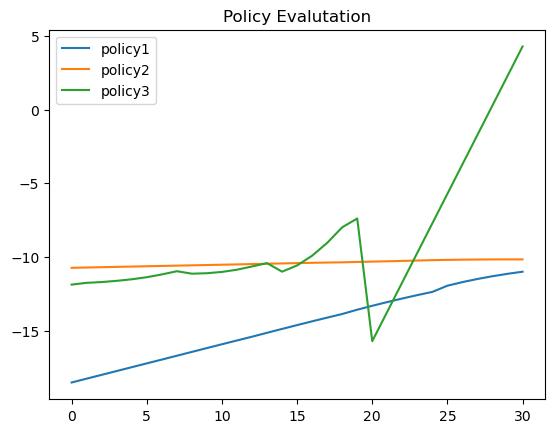

In [15]:
plt.plot(values1[:-1])
plt.plot(values2[:-1])
plt.plot(values3[:-1])
plt.title("Policy Evalutation")
plt.legend(['policy1','policy2','policy3'])
plt.show()

None of the policy are particularly great. Of course, policy 2 is better than policy 1, because we have actually a chance to gain a reward by making a double.

Now, we will try to do better by finding an optimal policy. We could implement the policy iteration algorithm or value iteration algorithm. We are going with the latter.

In [16]:
def valuesIteration(env):
    length = len(ACTIVE_STATES)+1
    values = [0]*length
    delta = float('inf')
    while delta > THETA:
        newValues = [0]*length
        for s in ACTIVE_STATES:
            evaluatedAction = [env.evalAction(a,s,values) for a in ACTIONS]
            newValues[s] = max(evaluatedAction)
        delta = max([abs(values[s] - newValues[s]) for s in ACTIVE_STATES]) 
        values = newValues.copy()
    return values

We still new to implement the policy improvement, in order to define a policy from our values.

In [17]:
def policyImprovement(values,env):
    policy=[]
    for s in ACTIVE_STATES:
        evaluatedAction = [env.evalAction(a,s,values) for a in ACTIONS]
        bestAction = ACTIONS[np.argmax(evaluatedAction)]
        policy.append([bestAction])
    return policy

We then put everything together to find the optimal policy, and the associated values.

In [18]:
iterativeValues = valuesIteration(game)
print(iterativeValues)
optimalPolicy = policyImprovement(iterativeValues,game)
showPolicy(optimalPolicy)
optimalValues = policyEvaluation(optimalPolicy,game)

[-1.453370939889808, -1.441383444026803, -1.4367938851718378, -1.4330841107578784, -1.4231183096342936, -1.3927077974269781, -1.3283841201053868, -1.2890550091209005, -1.2546059328671049, -1.2619871722783045, -1.2617073222520327, -1.22121888330913, -1.142502993311638, -1.3235969382360762, -1.3794706836983408, -1.3357593097746163, -1.1891881487590839, -0.8469882612617856, -0.3340521951358648, -0.8585701397151436, -1.2388582016968148, -1.8671641917908346, -1.6694829535312667, -0.6572261557684299, 0.6034985422740522, -2.775510204081633, -1.857142857142857, -0.8571428571428571, 0.4285714285714285, 3.428571428571429, 6.428571428571428, 0]
d d d d d d d d d d d d d d d d d d d d d d s s s s 1 1 3 3 3 

The strategy seems coherent: we start by rolling the dices two by two, until it is too risky to continue. Then we roll the dices one by one. At score 26 and 27, it is less costly to confront the dealer, even with more chance to lose than to win, than trying to roll a die to improve our score. In this situation, we want to have a factor 1, because we want to minimize the losses. Then, if our score is 28,29 or 30, we have a positive expectation. We then choose a factor 3 to maximize the gain.

We plot the values of the optimal strategy:

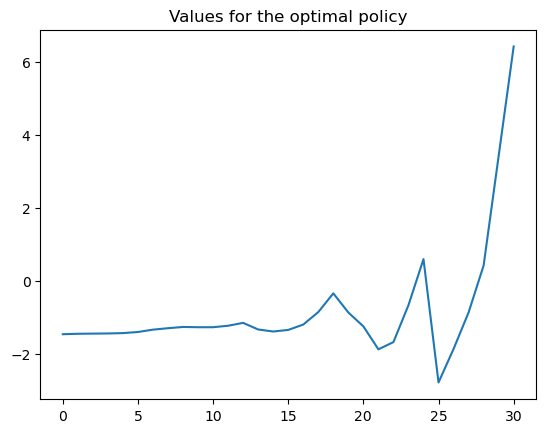

In [19]:
plt.plot(optimalValues[:-1])
plt.title('Values for the optimal policy')
plt.show()

We see with this graph that this policy is much better than the 3 others. However, we start with expectation around -2, which indicates that it isn't a game worth playing.

## Bonus: Monte Carlo

We start to implement a single game for given policy.

In [23]:
def playGame(policy,env:DiceGame,start=0):
    env.reset(min(start,31))
    reward=0
    while env.playerScore in ACTIVE_STATES:
        action = random.choice(policy[env.playerScore])
        env.playerScore,stepReward= env.step(action)
        reward+=stepReward
    return reward

In [24]:
def iterateGames(policy,env,n_games,start=0):
    mean = 0
    for k in range(n_games):
        mean += (playGame(policy,env,start)-mean)/(k+1)
    return mean

We can then estimate the mean using Monte-Carlo

In [25]:
mean1=iterateGames(policy1,game,10000)
mean2=iterateGames(policy2,game,10000)
mean3=iterateGames(policy3,game,10000)
meanOptimal=iterateGames(optimalPolicy,game,10000)
for mcMean, vMean in zip([mean1,mean2,mean3,meanOptimal],[values1[0],values2[0],values3[0],optimalValues[0]]):
    print("Estimation with Monte Carlo: ",mcMean," and computation with policy evaluation: ",vMean, " error: ",abs(mcMean-vMean))

Estimation with Monte Carlo:  -18.513599999999975  and computation with policy evaluation:  -18.517415750104878  error:  0.0038157501049020937
Estimation with Monte Carlo:  -10.77539999999999  and computation with policy evaluation:  -10.73633883281023  error:  0.03906116718976094
Estimation with Monte Carlo:  -11.809799999999981  and computation with policy evaluation:  -11.8738612027766  error:  0.0640612027766192
Estimation with Monte Carlo:  -1.5334000000000036  and computation with policy evaluation:  -1.4533694471274117  error:  0.08003055287259198


If we compare the mean found with Monte-Carlo to the value function for the state 0, we find that there are indeed very close. This is also what the theory predicts, which is always a good sign!